In [79]:
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from inverse_covariance import QuicGraphicalLassoEBIC
from sklearn.covariance import GraphicalLasso
from nilearn import plotting

import io
import dash
import dash_table
import dash_html_components as html
import base64

from jupyter_dash import JupyterDash 
import dash_cytoscape as cyto
from dash.dependencies import Input, Output, State
import dash_core_components as dcc

In [80]:
stylesheet = [{
        "selector": 'node',
        'style': {
            'position': 'absolute',
            'width': '50%',
            'height': '50%',
            'z-index': 999,
            "content": "data(label)",
            "font-size": "15px",
            "text-valign": "center",
            "text-halign": "center",
            "background-color": "#555",
            "text-outline-color": "#555",
            "text-outline-width": "2px",
            "color": "#FFFFFF",
            "overlay-padding": "6px",
            "z-index": "10"
        }
    },
    {    
        "selector": "edge",
          "style": {
            "curve-style": "haystack",
            "haystack-radius": "0.5",
            "line-color": "#bbb",
            "width": "mapData(weight, 0, 1, 1, 8)",
            "overlay-padding": "3px"
  }
},
    
    
    {
      "selector": "edge[weight<0]",
      "style": {
        "line-color": "#E85655",
        "width": "mapData(weight, -1, 0, 20, 1)",
        "opacity": "mapData(weight, 1, 0, 1, 0.4)",
  }
},
    
    {
      "selector": "edge[weight>0]",
      "style": {
        "line-color": "#6E8BC7",
        "width": "mapData(weight, 0, 1, 1, 20)",
        "opacity": "mapData(weight, 0, 1, 0.4, 1)",
  }
},

    
]

In [81]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets = external_stylesheets)
app.title = 'Network Capstone Design'

app.layout = html.Div([
    dcc.Upload(id = 'upload-data', 
        children = html.Div(['Drag and Drop or ', html.A('Select Files')]), 
               
        style = {
        'width': '100%',
        'height': '60px',
        'lineHeight': '60px',
        'borderWidth': '1px',
        'borderStyle': 'dashed',
        'borderRadius': '5px',
        'textAlign': 'center',
        'margin': '10px'
    },
        multiple=True          
    ),
               
    cyto.Cytoscape(id = 'cytoscape', 
        style = {
        'width': '100%',
        'height': '550px'
    }, 
                   
        layout = {
        'name': 'cose',
        'idealEdgeLength': 100,
        'nodeOverlap': 5,
        'refresh': 20,
        'fit': True,
        'padding': 10,
        'randomize': False,
        'componentSpacing': 200,
        'nodeRepulsion': 400000,
        'edgeElasticity': 100,
        'nestingFactor': 5,
        'gravity': 1,
        'numIter': 1000,
        'initialTemp': 200,
        'coolingFactor': 0.95,
        'minTemp': 1.0
    }, 
    
    stylesheet = stylesheet, 
    responsive = True),
        
    html.Div(id = "output-data-upload"),

])

In [82]:
@app.callback(
    [Output("output-data-upload", "children"), Output('cytoscape', 'elements')],
    [Input("upload-data", "contents"), Input("upload-data", "filename")])


def update_table(contents, filename):
    if contents:
        contents= contents[0]
        filename= filename[0]

        content_type, content_string = contents.split(",")
        decoded = base64.b64decode(content_string)

        try:
            if "csv" in filename:
                df= pd.read_csv(io.StringIO(decoded.decode("utf-8")))
            elif "xls" or "xlsx" in filename:
                df= pd.read_excel(io.BytesIO(decoded))
            elif "txt" or "tsv" in filename:
                df= pd.read_csv(io.StringIO(decoded.decode("utf-8")), delimiter=r"\s+")
        except Exception as e:
            print(e)
            return html.Div(["There was an error processing this file."])
        
        df = df.dropna(axis=1, how='all')
        df = df.dropna(axis=0, how='any')
        columnName = list(df.columns.values)
        
        best_alpha = Compute_BEST_GGM_from_extended_BIC(df, 0.1)
        
        estimator = QuicGraphicalLassoEBIC(lam=best_alpha, auto_scale =True, 
                                           verbose=1, tol=1.0e-4, 
                                           init_method='spearman', path=100, gamma=0.1, 
                                           max_iter=10000, method='quic')
        estimator.fit(df.values)

        df = pd.DataFrame(np.triu(-cov2corr(estimator.precision_),1))
        result = df
        result.to_csv (r'./mydf.csv', index = True, header=True)
        
        df.columns = columnName
        df.index = columnName
        
        table = html.Div(
            [
                
                dash_table.DataTable(
                    columns=[{"name": str(i), "id": str(i)} for i in df.columns],
                    data=df.to_dict("records"),
                    style_data={
                        'whiteSpace': 'normal',
                        'height': 'auto',
                    },
                ),
                
            ],
        )
    
        
        df = pd.DataFrame.from_dict(df)
        df = df.stack().reset_index()

        df.columns = ['from', 'to', 'weight']


        nodes = set()        
        cy_edges = []
        cy_nodes = []

        for index, row in df.iterrows():
            source, target, weight = row['from'], row['to'], row['weight']
    
    
            if(weight != 0):
                nodes.add(source)
                cy_nodes.append({"data": {"id": source, "label": source}})
                nodes.add(target)
                cy_nodes.append({"data": {"id": target, "label": target}})

                cy_edges.append({
                    'data': {
                        'source': source,
                        'target': target,
                        'weight': weight
                    }
                })
    
        elements = cy_edges+cy_nodes
        
        return table, elements

    else:
        return {}, {}


app.run_server(mode='external')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning: The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.
  func()


Dash app running on http://127.0.0.1:8050/


EBIC :1187.6854105277268 alpha :0.008818664
EBIC :1187.6853243721298 alpha :0.009238571
EBIC :1193.2768312607916 alpha :0.009678473
EBIC :1193.2766770084297 alpha :0.01013932
EBIC :1193.2767441066662 alpha :0.010622112
EBIC :1193.2768458543094 alpha :0.011127892
EBIC :1194.8483990080065 alpha :0.011657755
EBIC :1189.9682588121443 alpha :0.012212847
EBIC :1189.9681634599006 alpha :0.012794371
EBIC :1188.4711893876913 alpha :0.013403585
EBIC :1188.4713062864942 alpha :0.014041807
EBIC :1188.4712197744373 alpha :0.014710418
EBIC :1188.4710949340952 alpha :0.015410865
EBIC :1195.694739085642 alpha :0.016144665
EBIC :1192.1821701643594 alpha :0.016913406
EBIC :1192.1817066793203 alpha :0.01771875
EBIC :1192.1820116368895 alpha :0.018562442
EBIC :1192.1813903344662 alpha :0.019446307
EBIC :1192.1819712298498 alpha :0.020372257
EBIC :1192.1815217699457 alpha :0.021342298
EBIC :1192.181971188461 alpha :0.022358527
EBIC :1192.181676782402 alpha :0.023423145
EBIC :1192.1820223052728 alpha :0.024

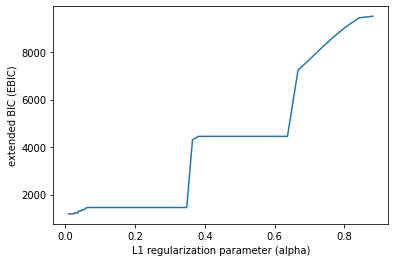

In [83]:
def skeptic(x):
    y = 2 * math.sin(math.pi/6. * x)
    return y

def npn(x):
    df = x.corr(method = "spearman")
    result = df.applymap(skeptic)

    return result

In [6]:
def lamSet(tr_):
    lamMax = max(np.max(tr_.values), -np.min(tr_.values))
    
    lamMin = 0.01 * lamMax
    lamMaxX = math.log(lamMax)
    lamMinX = math.log(lamMin)
    
    lam = np.exp(np.append(np.arange(lamMinX, lamMaxX, step = ((lamMaxX)-(lamMinX))/99), (lamMaxX)))
    
    return lam

In [29]:
def Compute_extended_BIC(model, cov, n, p, gamma):
    
    omega = model.precision_
    E=(np.sum(np.sum(omega != 0, axis=0))-p)*0.5
    MLE=n*(np.log(np.linalg.det(omega))-np.trace(np.dot(cov, omega)))
    EBIC=-MLE+E*np.log(n)+4*E*0.1*np.log(p)

    return EBIC

In [39]:
def Compute_BEST_GGM_from_extended_BIC(X,gamma):
    
    tr = npn(X)
    tr = tr.values
    tr_ = pd.DataFrame(np.triu(tr, 1))
    cov=np.cov(X.T)
    
    n=X.shape[0]
    p=X.shape[1]
    
    lam = lamSet(tr_)
    num_alphas=lam.shape[0]
    EBICs=np.zeros(num_alphas)
     
    for i in range(num_alphas):
        alpha=round(lam[i], 9)
        model = QuicGraphicalLassoEBIC(lam=alpha, auto_scale =False,
                                           verbose=1, tol=0.00001, 
                                           init_method='spearman', path=100, gamma=0.1, 
                                           max_iter=10000, method='quic').fit(X.values)
        
        EBIC=Compute_extended_BIC(model, tr, n, p, gamma)
        print("EBIC :"+str(EBIC)+" alpha :"+str(alpha))
        EBICs[i]=EBIC
         
    plt.plot(lam, EBICs)
    plt.xlabel("L1 regularization parameter (alpha)")
    plt.ylabel("extended BIC (EBIC)")
    plt.show()
    
    best_idx=np.argmin(EBICs)
    best_alpha=lam[best_idx]
    return float(best_alpha)

In [9]:
def cov2corr( A ):
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A